In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from sys import maxsize

### Setup

In [2]:
# DATA EXTRACTION
df_BOM = pd.DataFrame({
    'operation': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U'],
    'predecessor_operations': [[], [], ["A"], ["B"], ["C", "D"], ["E", "G"], ["H"], [], ["F"], [], [], [], ["J", "K", "L"], ["M"], ["N"], [], [], ["P", "Q"], ["R"], ["S", "U"], []],
    'end_product': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
    'due_date': [None, None, None, None, None, None, None, None, 50.0, None, None, None, None, None, 80.0, None, None, None, None, 30.0, None],
    'processing_time': [3, 2, 1, 3, 1, 3, 5, 7, 4, 18, 12, 3, 5, 10, 4, 1, 8, 7, 5, 1, 8],
    'workcenter': ['WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#2', 'WC#3', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#3', 'WC#1'],
    'machine': ["M1", "M2", "M3", "M2", "M4", "M5", "M1", "M2", "M3", "M4", "M5", "M1", "M2", "M3", "M2", "M3", "M4", "M5", "M1", "M4", "M2"]
})
df_machine = pd.DataFrame({
    'workcenter': ["WC#1", "WC#2", "WC#3"],
    'M1': [3, 2, 3],
    'M2': [2, 1, 2],
    'M3': [1, 2, 1],
    'M4': [1, 1, 1],
    'M5': [1, 2, 3]
})
display(df_BOM)
display(df_machine)

class WorkCenter:
    def __init__(self, id, dict_machines={}):
        self.id = id
        self.machines = dict_machines
        # dict_machines = {'M1': [ [], [], [] ] }
        # this means that there are 3 M1 machines
        # the [] nested inside the list refers to the usage timings of the i-th M1 machine
        # for example: [ [(0,3), (4,5)], [], []]
        # means that the 1st machine is used from (0,3) and (4,5)

class Operation:
    def __init__(self, id, processing_time, workcenter, machine, due_date=None, successors=None):
        self.id = id
        # Precedence constraints
        self.successors = successors if successors else []

        # Workcenter and machine information
        self.workcenter = workcenter
        self.machine = machine

        # Times
        self.processing_time = processing_time
        self.start_time = None
        self.end_time = None
        self.due_date = None if due_date != due_date else due_date

        # Other
        self.scheduled = False

factory = {}
for idx, row in df_machine.iterrows():
    workcenter = row['workcenter']
    dict_machines = {}
    for machine in (df_machine.columns[1:]): 
        dict_machines[machine] = [[] for _ in range(row[machine])]
    # factory.append(WorkCenter(workcenter, dict_machines=dict_machines))
    factory[workcenter] = WorkCenter(workcenter, dict_machines=dict_machines)

,operation,predecessor_operations,end_product,due_date,processing_time,workcenter,machine
0,A,[],0,NaN,3,WC#2,M1
1,B,[],0,NaN,2,WC#1,M2
2,C,[A],0,NaN,1,WC#1,M3
3,D,[B],0,NaN,3,WC#2,M2
4,E,"[C, D]",0,NaN,1,WC#2,M4
5,F,"[E, G]",0,NaN,3,WC#2,M5
6,G,[H],0,NaN,5,WC#2,M1
7,H,[],0,NaN,7,WC#3,M2
8,I,[F],1,50.0,4,WC#2,M3
9,J,[],0,NaN,18,WC#1,M4


,workcenter,M1,M2,M3,M4,M5
0,WC#1,3,2,1,1,1
1,WC#2,2,1,2,1,2
2,WC#3,3,2,1,1,3


### Functions

In [3]:
def find_critical_path(operations, operation_ids):
    """
    Finds the critical path among the feasible operations.
    Inputs:
        - operations                    : dictionary {operation_id: Operation()}, a dictionary of all operations.
        - operation_ids                 : list[operation_id],  a list of operation IDs that are currently feasible.
    Output:
        - (critical_path, path_length)  : tuple, containing the critical path (list of operation IDs) and the length of the critical path.
    """

    paths = []
    def dfs(operation_id, current_path, current_length):
        """
        Performs depth-first-search in a given operation network using recursion.
        Inputs: 
            - operation_id          : str, id of the operation to begin DFS at
            - current_path          : list [str], The path of operation IDs visited so far
            - current_length        : float - The cumulative processing time along the current path
        Output:
            - None - The function modifies the 'paths' list in place, adding tuples of (path, length) for each terminal path found.
        Explanation:
            - This function recursively traverses the operation network starting from the given operation_id.
            - It explores all successors of the current operation, appending the current operation to the path and adding its processing time to the cumulative length.
            - If an operation has no successors, it adds the complete path and its length to the 'paths' list.
        """

        operation = operations[operation_id]
        # If the operation has a successor, add to path
        # Otherwise, perform forward recursive DFS on each of the operation's successor to explore all possible paths
        if not operation.successors:
            paths.append((current_path + [operation_id], current_length + operation.processing_time))
        else:
            for succ_id in operation.successors:
                dfs(succ_id, current_path + [operation_id], current_length + operation.processing_time)

    # For every operation, perform DFS
    for op_id in operation_ids:
        dfs(op_id, [], 0)
    return max(paths, key=lambda x: x[1])

def schedule_operations(operations, due_dates, factory):
    """
    Solves the assembly scheduling problem (ASP) using the Longest End Time Scheduling Algorithm (LETSA).
    Inputs:
        - operations            : dictionary {operation_id: Operation()}, a dictionary of all operations.
        - due_dates             : dictionary {operation_id: int}, a dictionary of due dates for each operation.
        - factory               : list [WorkCenter()], a list of WorkCenter objects, containing machine information and availability
    Output:
        - scheduled_operations  : list [Operation()], a list of Operation objects with start and end time schedules.
    """

    scheduled_operations = []
    # [[Step 4]]
    while True:
        # ================================================================================================================
        #  [[4.0]] Feasible operations = every operation that is (1) not scheduled, and (2) has all successors scheduled
        # ================================================================================================================
        feasible_operations = [op_id for op_id, op in operations.items() if not op.scheduled and all(operations[succ_id].scheduled for succ_id in op.successors)]
        if not feasible_operations:
            break # terminate if all operations have been scheduled

        # ===================================================================
        #  [[4.1 - 4.3]] Compute critical path only for feasible operations
        # ===================================================================
        critical_path, _ = find_critical_path(operations, feasible_operations)
        operation_id = critical_path[0]
        operation = operations[operation_id]
        print(operation_id)

        # =====================================================================
        # [[4.4]] Set completion/end time of the selected operation as
        #         (ii) the start time of the successor, if a successor exists
        #         (ii) the project deadline, otherwise 
        # =====================================================================
        if operation.successors: # if the operation has successors 
            # then the tentative end time is the earliest / min of the start time of all successors
            tentative_end_time = min(operations[succ_id].start_time for succ_id in operation.successors)
        else: 
            # else, the operation is an end product and its completion time must be its deadline
            tentative_end_time = due_dates[operation.id]

        # ============================================================================
        #   [[4.5]] For each identical machine incuded in the required work-center 
        # ============================================================================
        current_workcenter_id = operation.workcenter
        current_workcenter = factory[current_workcenter_id]             # WorkCenter object 
        machine_type = operation.machine                                # machine id of required machine
        possible_machines = current_workcenter.machines[machine_type]   # [[], [], []]

        earliest_start_time = float('inf')
        selected_machine = None
        for machine_idx, machine_schedule in enumerate(possible_machines):
            print(machine_idx, machine_schedule)
            if not machine_schedule:  # If machine schedule is empty, then machine is immediately useable
                available_start_time = 0
            else:
                # available_start_time = machine_schedule[-1][1]  # Get the end time of the last scheduled operation on this machine
                available_start_time = machine_schedule[0][1]  # Get the end time of the last scheduled operation on this machine

            if available_start_time < earliest_start_time:
                earliest_start_time = available_start_time
                selected_machine = machine_schedule

        # ============================================================================
        #   [[4.6]] Schedule the operation Jc at the latest available starting time 
        # ============================================================================
        start_time = min(earliest_start_time, tentative_end_time - operation.processing_time)
        end_time = start_time + operation.processing_time

        operation.start_time = start_time
        operation.end_time = end_time
        operation.scheduled = True
        selected_machine.append((start_time, end_time))
        scheduled_operations.append(operation)
        
    return scheduled_operations

def plot_gantt_chart(scheduled_operations):
    """
    Plots a Gantt chart for the scheduled operations.
    Inputs:
        - scheduled_operations      : list Operation(), a list of scheduled Operation objects.
    Output:
        - None 
        - Displays a Gantt chart.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    for op in scheduled_operations:
        ax.barh(op.id, op.processing_time, left=op.start_time, color='skyblue')
        ax.text(op.start_time + op.processing_time / 2, op.id, f'{op.start_time}-{op.end_time}', ha='center', va='center', color='black')

    ax.set_xlabel('Time')
    ax.set_ylabel('Operations')
    ax.set_title('Gantt Chart for Assembly Scheduling')
    plt.grid(True)
    plt.show()

def load_operations_from_df(df):
    """
    Loads operations from a DataFrame and creates Operation objects.    
    Inputs:
        - df: pandas DataFrame - A DataFrame containing BOM information with columns 
          ['part', 'operation', 'operation_id', 'components_required', 'processing_time', 'workcenter', 'predecessor_operations'].
    Output:
        - operations: dictionary, {operation_id: Operation()} - A dictionary of Operation objects.
    """
    operations = {}
    for idx, row in df.iterrows():
        operation_id = row['operation']
        successors = row['predecessor_operations']
        due_date = row['due_date']  
        operations[operation_id] = Operation(operation_id, row['processing_time'], row['workcenter'], row['machine'], due_date=due_date, successors=successors)
        
    return operations


def load_due_dates(df):
    """
    Generates due dates for each operation.    
    Inputs:
        - df: pandas DataFrame - A DataFrame containing BOM information.
    Output:
        - due_dates: dictionary, {operation_id: int} - A dictionary of due dates for each operation.
    """
    due_dates = {}
    for idx, row in df.iterrows():
        operation_id = row['operation']
        # Example due date assignment, this should be adjusted as per actual due dates
        due_dates[operation_id] = 20 - idx  # Example: descending due dates
    return due_dates


### Execution

J
0 []
K
0 []
1 []
Q
0 [(-7, 11)]
U
0 []
1 []
H
0 []
1 []
G
0 []
1 []
A
0 [(-5, 0)]
1 []
C
0 []
L
0 []
1 []
2 []
M
0 []
N
0 []
1 []
O
0 [(0, 7)]
1 []
B
0 [(-8, 0)]
1 []
D
0 [(-12, -7)]
E
0 []
F
0 [(-2, 10)]
1 []
I
0 [(-22, -12)]
1 []
P
0 [(-22, -12), (-15, -11)]
1 []
R
0 []
S
0 [(-5, 0), (0, 3)]
1 []
T
0 []


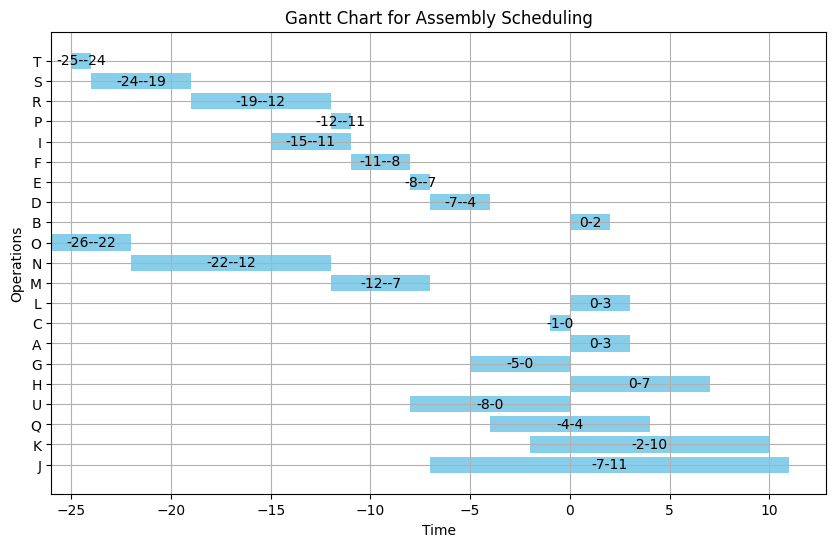

In [4]:
operations = load_operations_from_df(df_BOM)
due_dates = load_due_dates(df_BOM)

# # Schedule operations
scheduled_operations = schedule_operations(operations, due_dates, factory)

# # Plot Gantt chart
plot_gantt_chart(scheduled_operations)

In [5]:
for x, workcenter in factory.items():
    print(workcenter.machines)

{'M1': [[], [], []], 'M2': [[(-8, 0), (0, 2)], []], 'M3': [[(-1, 0)]], 'M4': [[(-7, 11), (-4, 4)]], 'M5': [[(-19, -12)]]}
{'M1': [[(-5, 0), (0, 3), (-24, -19)], []], 'M2': [[(-12, -7), (-7, -4)]], 'M3': [[(-22, -12), (-15, -11), (-12, -11)], []], 'M4': [[(-8, -7)]], 'M5': [[(-2, 10)], [(-11, -8)]]}
{'M1': [[(0, 3)], [], []], 'M2': [[(0, 7)], [(-26, -22)]], 'M3': [[]], 'M4': [[(-25, -24)]], 'M5': [[], [], []]}


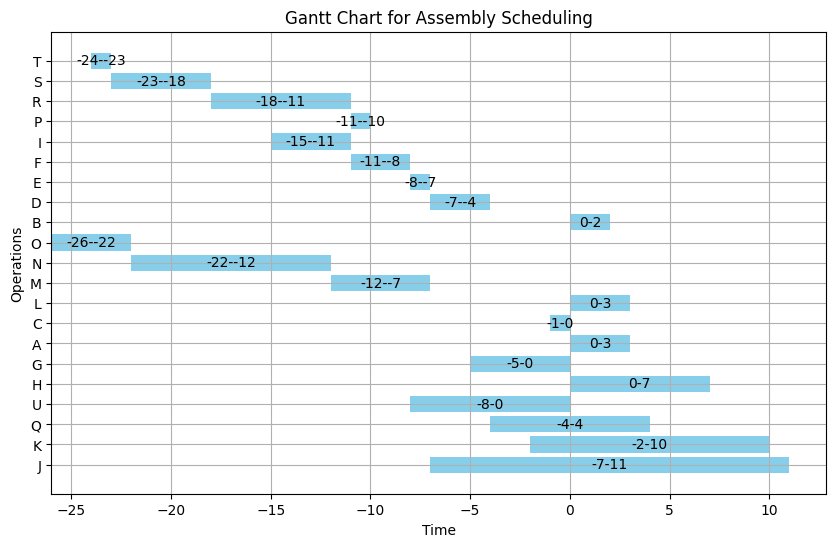

In [6]:
df_BOM = pd.DataFrame({
    'operation': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U'],
    'predecessor_operations': [[], [], ["A"], ["B"], ["C", "D"], ["E", "G"], ["H"], [], ["F"], [], [], [], ["J", "K", "L"], ["M"], ["N"], [], [], ["P", "Q"], ["R"], ["S", "U"], []],
    'end_product': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
    'due_date': [None, None, None, None, None, None, None, None, 50.0, None, None, None, None, None, 80.0, None, None, None, None, 30.0, None],
    'processing_time': [3, 2, 1, 3, 1, 3, 5, 7, 4, 18, 12, 3, 5, 10, 4, 1, 8, 7, 5, 1, 8],
    'workcenter': ['WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#2', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#2', 'WC#3', 'WC#2', 'WC#2', 'WC#3', 'WC#2', 'WC#1', 'WC#1', 'WC#2', 'WC#3', 'WC#1'],
    'machine': ["M1", "M2", "M3", "M2", "M4", "M5", "M1", "M2", "M3", "M4", "M5", "M1", "M2", "M3", "M2", "M3", "M4", "M5", "M1", "M4", "M2"]
})
df_machine = pd.DataFrame({
    'workcenter': ["WC#1", "WC#2", "WC#3"],
    'M1': [3, 2, 3],
    'M2': [2, 1, 2],
    'M3': [1, 2, 1],
    'M4': [1, 1, 1],
    'M5': [1, 2, 3]
})

class WorkCenter:
    def __init__(self, id, dict_machines={}):
        self.id = id
        self.machines = dict_machines

factory = {}
for idx, row in df_machine.iterrows():
    workcenter = row['workcenter']
    dict_machines = {}
    for machine in (df_machine.columns[1:]): 
        dict_machines[machine] = [[] for _ in range(row[machine])]
    factory[workcenter] = WorkCenter(workcenter, dict_machines=dict_machines)

class Operation:
    def __init__(self, id, processing_time, workcenter, machine, due_date=None, successors=None):
        self.id = id
        self.successors = successors if successors else []
        self.workcenter = workcenter
        self.machine = machine
        self.processing_time = processing_time
        self.start_time = None
        self.end_time = None
        self.due_date = None if due_date != due_date else due_date
        self.scheduled = False

def find_critical_path(operations, operation_ids):
    paths = []
    def dfs(operation_id, current_path, current_length):
        operation = operations[operation_id]
        if not operation.successors:
            paths.append((current_path + [operation_id], current_length + operation.processing_time))
        else:
            for succ_id in operation.successors:
                dfs(succ_id, current_path + [operation_id], current_length + operation.processing_time)
    for op_id in operation_ids:
        dfs(op_id, [], 0)
    return max(paths, key=lambda x: x[1])

def schedule_operations(operations, due_dates, factory):
    scheduled_operations = []
    while True:
        feasible_operations = [op_id for op_id, op in operations.items() if not op.scheduled and all(operations[succ_id].scheduled for succ_id in op.successors)]
        if not feasible_operations:
            break

        critical_path, _ = find_critical_path(operations, feasible_operations)
        operation_id = critical_path[0]
        operation = operations[operation_id]

        if operation.successors:
            tentative_end_time = min(operations[succ_id].start_time for succ_id in operation.successors)
        else:
            tentative_end_time = due_dates[operation.id]

        current_workcenter_id = operation.workcenter
        current_workcenter = factory[current_workcenter_id]
        required_machine = operation.machine
        possible_machines = current_workcenter.machines[required_machine]

        earliest_start_time = float('inf')
        selected_machine = None
        for machine_idx, machine_schedule in enumerate(possible_machines):
            if not machine_schedule:
                available_start_time = 0
            else:
                available_start_time = machine_schedule[-1][1]

            if available_start_time < earliest_start_time:
                earliest_start_time = available_start_time
                selected_machine = machine_schedule

        start_time = min(earliest_start_time, tentative_end_time - operation.processing_time)
        end_time = start_time + operation.processing_time

        operation.start_time = start_time
        operation.end_time = end_time
        operation.scheduled = True
        selected_machine.append((start_time, end_time))
        scheduled_operations.append(operation)
        
    return scheduled_operations

def plot_gantt_chart(scheduled_operations):
    fig, ax = plt.subplots(figsize=(10, 6))
    for op in scheduled_operations:
        ax.barh(op.id, op.processing_time, left=op.start_time, color='skyblue')
        ax.text(op.start_time + op.processing_time / 2, op.id, f'{op.start_time}-{op.end_time}', ha='center', va='center', color='black')
    ax.set_xlabel('Time')
    ax.set_ylabel('Operations')
    ax.set_title('Gantt Chart for Assembly Scheduling')
    plt.grid(True)
    plt.show()

def load_operations_from_df(df):
    operations = {}
    for idx, row in df.iterrows():
        operation_id = row['operation']
        successors = row['predecessor_operations']
        due_date = row['due_date']
        operations[operation_id] = Operation(operation_id, row['processing_time'], row['workcenter'], row['machine'], due_date=due_date, successors=successors)
    return operations

def load_due_dates(df):
    due_dates = {}
    for idx, row in df.iterrows():
        operation_id = row['operation']
        due_dates[operation_id] = 20 - idx
    return due_dates

# Load operations and due dates from DataFrame
operations = load_operations_from_df(df_BOM)
due_dates = load_due_dates(df_BOM)

# Schedule operations
scheduled_operations = schedule_operations(operations, due_dates, factory)

# Plot Gantt chart
plot_gantt_chart(scheduled_operations)


### Test Case

In [7]:
df_BOM = pd.DataFrame({
    'operation': ['F.10', 'F.20', 'D.10', 'C.10', 'A.10', 'A.20'],
    'predecessor_operations': [[], ['F.10'], [], ['D.10'], [], ['A.10']],
    'end_product': [0, 0, 0, 0, 0, 1],
    'due_date': [0, 0, 0, 0, 0, 14],
    'processing_time': [2, 3, 3, 1, 5, 2],
    'workcenter': ["WC#2", "WC#1", "WC#1", "WC#1", "WC#1", "WC#2"],
    'machine': ['M1', 'M1', 'M1', 'M1', 'M1', 'M1']
})
display(df_BOM)
df_machine = pd.DataFrame({
    'workcenter': ["WC#1", "WC#2"],
    'M1': [1, 1]
})
display(df_machine)

,operation,predecessor_operations,end_product,due_date,processing_time,workcenter,machine
0,F.10,[],0,0,2,WC#2,M1
1,F.20,[F.10],0,0,3,WC#1,M1
2,D.10,[],0,0,3,WC#1,M1
3,C.10,[D.10],0,0,1,WC#1,M1
4,A.10,[],0,0,5,WC#1,M1
5,A.20,[A.10],1,14,2,WC#2,M1


,workcenter,M1
0,WC#1,1
1,WC#2,1


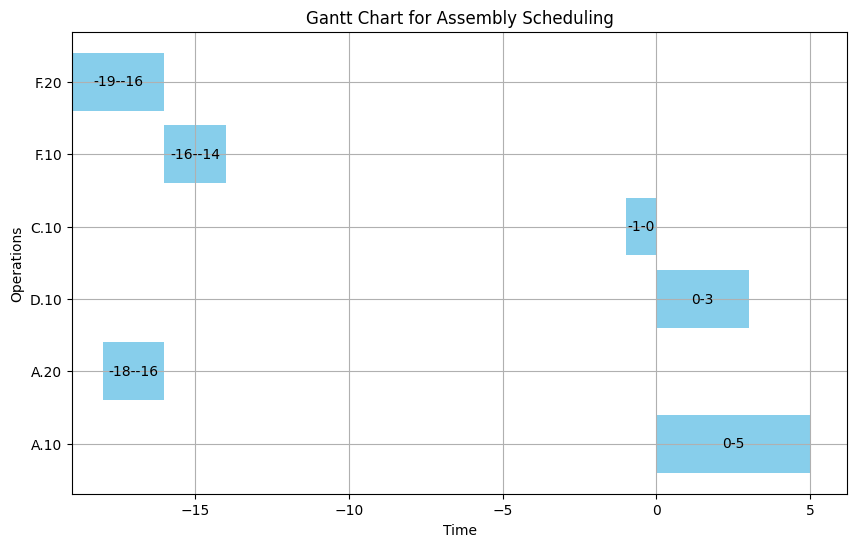

In [8]:
operations = load_operations_from_df(df_BOM)
due_dates = load_due_dates(df_BOM)

# # Schedule operations
scheduled_operations = schedule_operations(operations, due_dates, factory)

# # Plot Gantt chart
plot_gantt_chart(scheduled_operations)